#**Flowers CNN Josemaría A01612376**

##Importación de bibliotecas

Algunas de las bibliotecas incluyen warnings para gestionar advertencias, numpy y pandas para manipulación de datos, matplotlib y seaborn para visualización, y varias bibliotecas relacionadas con aprendizaje profundo, como Keras y TensorFlow.

In [21]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configure
# Sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Preprocess.
from keras.preprocessing.image import ImageDataGenerator

# Dl libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# Specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# Specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

##Almacenamiento de imágenes

X=[] y Z=[]: Listas vacías que se utilizarán para almacenar los datos de las imágenes y sus etiquetas correspondientes. X se usará para almacenar las imágenes, y Z se utilizará para almacenar las etiquetas de las flores.

IMG_SIZE=150: Tamaño al que se redimensionarán todas las imágenes antes de cargarlas en el modelo. Todas las imágenes se redimensionarán a un tamaño cuadrado de 150x150 píxeles.

FLOWER_DAISY_DIR, FLOWER_SUNFLOWER_DIR, FLOWER_TULIP_DIR, FLOWER_DANDI_DIR, y FLOWER_ROSE_DIR: Estas son variables que almacenan las rutas de los directorios que contienen las imágenes de diferentes tipos de flores.

In [66]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR = 'C:\\Users\Josem\Documents\\daisy'
FLOWER_SUNFLOWER_DIR='C:\\Users\Josem\Documents\\sunflower'
FLOWER_TULIP_DIR= 'C:\\Users\Josem\Documents\\tulip'
FLOWER_DANDI_DIR='C:\\Users\Josem\Documents\\dandelion'
FLOWER_ROSE_DIR='C:\\Users\Josem\Documents\\rose'


Función para asignar etiquetas a las imágenes de flores. Aquí está la explicación de la función:

In [67]:
def assign_label(img,flower_type):
    return flower_type

Función para procesar imágenes las imágenes (especificado por flower_type y ubicado en el directorio DIR). Para cada imagen, se asigna una etiqueta, se redimensiona a un tamaño común y se almacena tanto la imagen como su etiqueta en las listas X y Z. Estas listas se utilizarán posteriormente para el entrenamiento del modelo. La función tqdm se utiliza para mostrar una barra de progreso durante el procesamiento de las imágenes.

In [68]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [69]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:01<00:00, 439.30it/s]

764


In [70]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:01<00:00, 390.07it/s]

1497


In [71]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:10<00:00, 95.94it/s] 

2481


In [72]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:02<00:00, 382.38it/s]

3533


In [73]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:07<00:00, 108.88it/s]

4317


Muestra con selección aleatoria de imágenes de flores procesadas en una cuadrícula de 5 filas por 2 columnas.

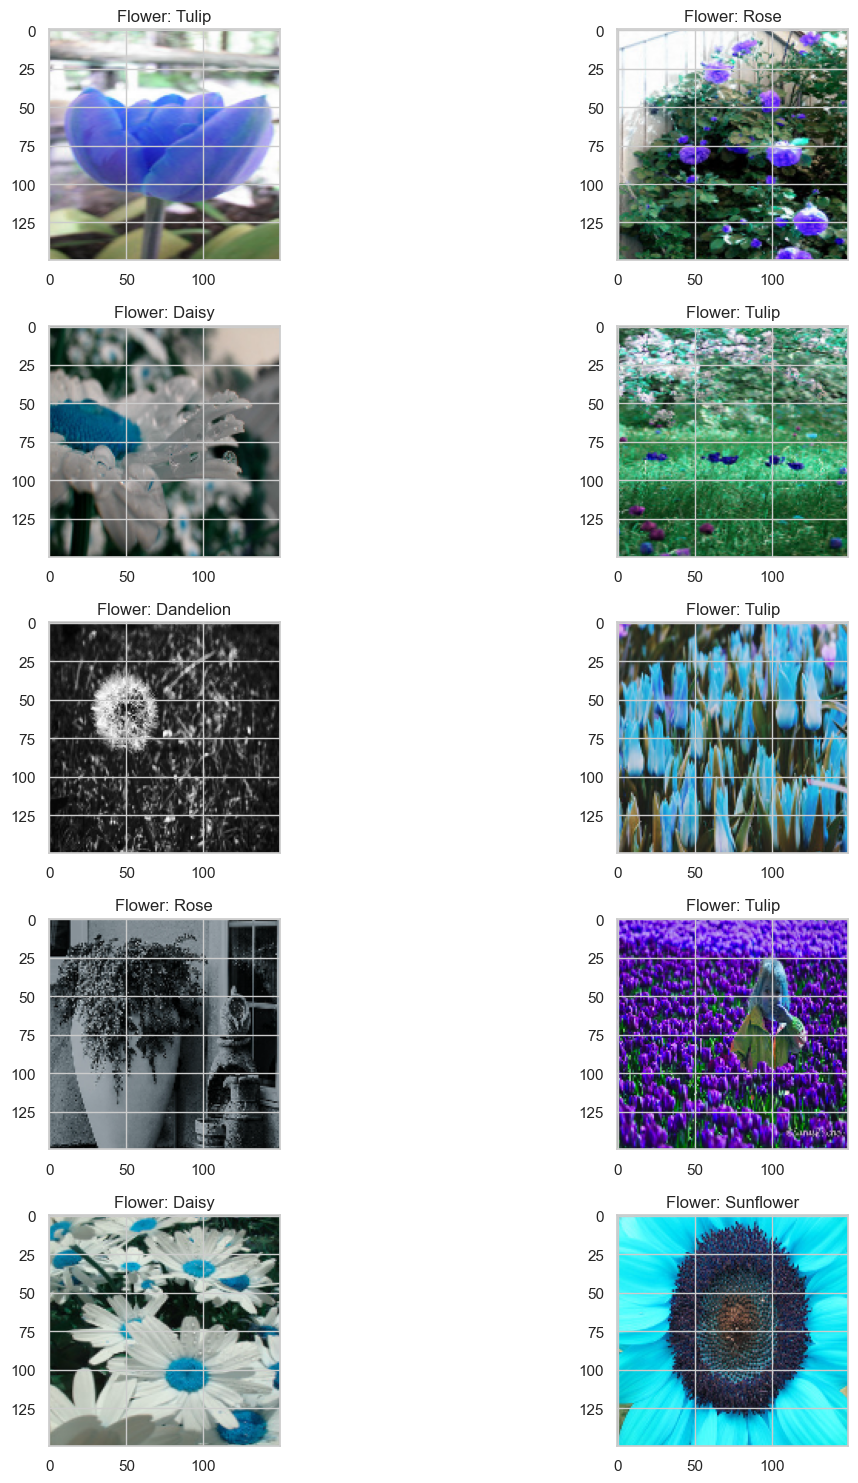

In [74]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()

Preparación de los datos para el entrenamiento del modelo. Las etiquetas se codifican numéricamente, se convierten en formato categórico, las imágenes se convierten en arreglos NumPy y se normalizan para asegurar que estén en el rango adecuado antes de alimentarlas al modelo.

In [75]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

Se divide el conjunto de datos en conjuntos de train y test.

In [76]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

Se establecen las semillas aleatorias para diferentes bibliotecas. Al fijar las semillas, se asegura de que los mismos números aleatorios se utilicen en cada ejecución, lo que facilita la comparación de resultados y la depuración de problemas.

In [77]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

El modelo posee una arquitectura de CNN, consta de capas convolucionales y de max pooling intercaladas con capas completamente conectadas. Las capas convolucionales se utilizan para extraer características de las imágenes, y las capas de max pooling reducen la resolución espacial. El modelo se entrena para clasificar las imágenes en una de las cinco clases de flores utilizando la capa final de salida con activación softmax.

In [78]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

Se configuran los hiperparámetros del tamaño del lote y el número de épocas de entrenamiento, y se establece un callback (ReduceLROnPlateau) que se utilizará para ajustar la tasa de aprendizaje durante el entrenamiento del modelo. La reducción de la tasa de aprendizaje es útil para permitir un entrenamiento más preciso y estable a medida que el modelo se acerca a la convergencia.

In [79]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

Se aplican diversas transformaciones aleatorias a las imágenes de train, lo que ayuda a aumentar la variabilidad de los datos y mejora la capacidad del modelo para generalizar a nuevas imágenes.

In [80]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

Se compila el modelo de la CNN antes de comenzar el proceso de entrenamiento.

In [81]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 18, 18, 96)       

Proceso de entrenamiento, donde el modelo ajustará sus pesos y bias utilizando los datos de train y calculará la pérdida y las métricas en los datos de train y validación en cada época. History captura esta información y se utiliza posteriormente para visualizar y analizar el progreso del entrenamiento, como la evolución de la pérdida y la precisión a lo largo de las épocas.

In [83]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
25/25 [==============================] - 70s 3s/step - loss: 1.4519 - accuracy: 0.3400 - val_loss: 1.2114 - val_accuracy: 0.4620
Epoch 2/50
25/25 [==============================] - 62s 2s/step - loss: 1.2328 - accuracy: 0.4799 - val_loss: 1.0905 - val_accuracy: 0.5370
Epoch 3/50
25/25 [==============================] - 61s 2s/step - loss: 1.1108 - accuracy: 0.5590 - val_loss: 0.9969 - val_accuracy: 0.6213
Epoch 4/50
25/25 [==============================] - 68s 3s/step - loss: 1.0302 - accuracy: 0.6063 - val_loss: 0.9797 - val_accuracy: 0.6009
Epoch 5/50
25/25 [==============================] - 74s 3s/step - loss: 0.9724 - accuracy: 0.6279 - val_loss: 0.9318 - val_accuracy: 0.6287
Epoch 6/50
25/25 [==============================] - 64s 3s/step - loss: 0.9159 - accuracy: 0.6552 - val_loss: 0.8521 - val_accuracy: 0.6611
Epoch 7/50
25/25 [==============================] - 60s 2s/step - loss: 0.8834 - accuracy: 0.6623 - val_loss: 0.9011 - val_accuracy: 0.6389
Epoch 8/50
25/25 [==

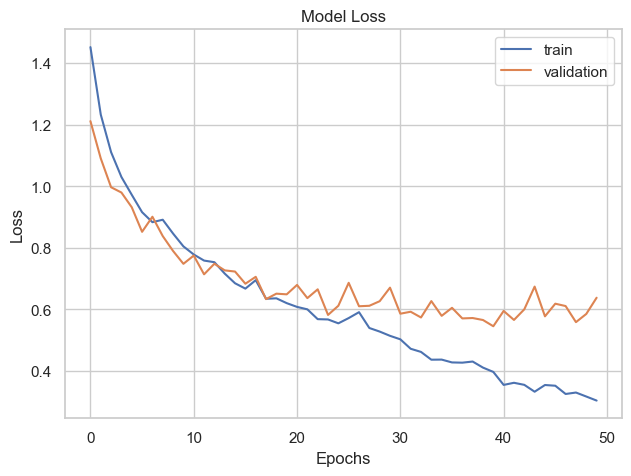

In [85]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

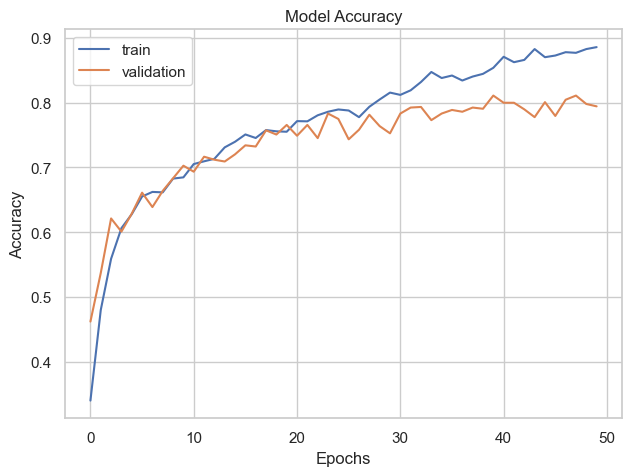

In [86]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [88]:
model.save('flowers_model.h5')
model.save('flowers.keras')